# PRA 2: Deep Learning para el análisis de textos

En esta práctica revisaremos y aplicaremos los conocimientos aprendidos durante los últimos módulos del curso. En concreto trataremos los siguientes temas:

1. **Traducción automática(TA)**: con custom embeddings y con embeddings preentrenados.
2. **NER y NEL**: Entrenamiento de modelos de detección de entidades nombradas (NER), uso y clasificación.  Detección de entidades nombradas basándonos en Wikidata aplicada a NER.

También incluimos algunos otros temas transversales trabajados a lo largo de la asignatura.


#0. Conexión con drive

La ejecución de esta sección es opcional, pero muy recomendable si se trabaja en Colab.


Aquí se realiza la conexión con drive y se establece el directorio de trabajo *actual*, en el que se almacenarán todos los recursos necesarios para ejecutar el notebook.



El path de trabajo se debería colocar en la variable `my_path_pra2` y se sugiere crear una estructura de directorios como la siguiente.

**Estructura de directorios**

Establecer el directorio raiz según la variable `my_path_pra2`. En este directorio se almacenarán los datasets y directorios necesarios para la ejecución del notebook. La estructura y contenidos son los siguientes:

    * directorio `TA` donde se almacenan los datos y recursos para realizar la traducción automática; contiene:
      * glove.42B.300d.txt    # cargado por el usuario
      * nld.txt      # cargado por el usuario
      * directorio `model` donde se almacenan los *best model* del entrenamiento de los modelos de traducción automática:
        * model_ta_en_de-g.keras    # 'best model' generado por el entrenamiento de TA con embeddings preentrenados
        * model_ta_en_de.keras      # 'bestmodel' generado por el entrenamiento de TA con embeddings preentrenados
    * directorio `NER` con los archivos necesarios para la práctica NER:
        * Directorio `output_ner`   donde se almacena el *model-best* y *model-last* entrenados por este notebook
        * config.cfg    # cargado por el usuario
        * test.txt      # cargado por el usuario
        * test.spacy    # Conversión de test.txt al formato spacy
        * train.txt     # cargado por el usuario
        * train.spacy   # Conversión de train.txt al formato spacy
        * valid.txt     # cargado por el usuario
        * valid.spacy   # Conversión de valid.txt al formato spacy



**Ejecución de notebook en un entorn no `Colab`.**

Si no se va a ejecutar este notebook en Colab, substituir esta sección (*0. Conexión on Drive*) por la correspondiente a la configuración deseada, teniendo en cuenta disponer de GPU con al menos 15 GB de memoria RAM.

**Ejecucón de notebok en un entorno `Colab`.**

Si se ejectua este notebook en Colab, debe utilizarse con al menos una GPU del tipo 'T4 GPU' o superior. Tener en cuenta que si se utiliza el servicio gratuito de Colab, estas GPU no están disponibles permanentemente y, cuando están disponibles, lo están solo mientras duran las 'compute units' asignadas al usuario o por límites de disponibilidad de GPUs de Google. Cuando éstas se agotan o no hay disponibilidad, debe esperarse a una nueva asignación. Google no publica el método de asignación o los [plazos de disposición](https://research.google.com/colaboratory/faq.html#usage-limits) de GPUs. La estructura de los directorios de trabajo debe ser la misma que la mencionada en el apartado anterior.

In [ ]:
# Acceder a Colab myDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Update path as needed; maintain the structure described.

my_path_pra2 = "/content/drive/MyDrive/"

if os.path.exists(my_path_pra2):
    try:
        os.chdir(my_path_pra2)
        print(f"Root directory: '{os.getcwd()}'")
    except Exception as e:
        print(f"Error  changing directory: '{my_path_pra2}'. Error: {e}")
else:
    print(f"Directory '{my_path_pra2}' doesn't exist")

Root directory: '/content/drive/MyDrive'


# Imports

In [ ]:
#############################################
# SOLUCIÓ                                   #
#############################################

import keras
from keras import optimizers
from keras.utils import pad_sequences
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, RepeatVector

# ... Other imports ...

# 1. Traducción Automática (TA) (7 puntos)


En esta primera parte de la práctica se pide resolver los ejercicios usando la libreria **KERAS**.

## 1.1 TA con Custom Embeddings (4,5 puntos)


El objetivo de este apartado es entrenar un modelo de traducción automática de dos idiomas escogidos a partir del dataset elegido, siguiendo los mismos pasos que en el notebook de *Machine Translation* y el ejemplo proporcionado para el desarrollo de esta práctica `Ejemplo_PRA2`.

<strong>Implementación:</strong> Siguiendo los pasos trabajados en el notebook de traducción automática, implementar y entrenar un modelo de traducción automática, del **idioma origen** a **idioma destino**. Para ello, considerar los siguientes aspectos: <br>
    - Decidir que dimensión que se usará en la capa embedding. Se sugiere empezar con 200 y luego se pedirá variar este valor para comparar los resultados.<br>
    - Plantear una longitud de secuencia que tenga sentido. Inicialmente, se pedirá trabajar con 8, y su valor se ajustará según la carga de procesamiento.<br>
    - Mostrar la aplicación del modelo entrenado (predicción) con datos del dataset de test.<br>
 <br>

### 1.1.0 Hiperparàmetres

Notar que:

* En este ejercicio utilitzaremos  'max_text_length' tanto para la secuencia de entrada como para la de salida.

In [ ]:
# Model hyperparameters

max_text_length = 8        # Maximum number of tokens allowed per input  and output sequence
embedding_vec_length = 200     # Dimensionality of the dense vector representing each token.
units = 512                    # LSTM Layer Units
epochs = 50                    # Training epochs
patience = 5                 # early stopping patience
batch_size = 64               # Number of training examples per step

### 1.1.1 Preparación de datos (1 punto)

Primero preparamos los datos que se han elegido (tened en cuenta que el idioma origen debe ser **inglés**), de tal manera que, se puedan leer correctamente y estén preparados para tenerlos en un formato adecuado para la práctica.

**a. Cargamos los datos desde la fuente seleccionada.**

*Salidas esperadas:*
- Longitud del dataset.
- Al menos 3 filas de datos en las que se muestre textos del idioma origen y la respectiva traducción.

In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################

ruta_en = "/content/drive/MyDrive/TED2020.en-es.en"
ruta_es = "/content/drive/MyDrive/TED2020.en-es.es"

# función de carga
def load_data(path_en, path_es):
    with open(path_en, 'r', encoding='utf-8') as f:
        en_lines = f.read().split('\n')
    with open(path_es, 'r', encoding='utf-8') as f:
        es_lines = f.read().split('\n')
    return en_lines, es_lines

# Cargar y procesar
raw_en, raw_es = load_data(ruta_en, ruta_es)

# Emparejamos los datos y limpiamos líneas vacías
data = []
for en, es in zip(raw_en, raw_es):
    if en.strip() and es.strip():
        data.append([en.strip(), es.strip()])

# resultados
print(f"Longitud del dataset: {len(data)} pares de frases.")
print("\nMuestra de las 3 primeras filas (Origen -> Destino):")
for i in range(min(3, len(data))):
    print(f"{i+1}. EN: {data[i][0]}")
    print(f"   ES: {data[i][1]}")

Longitud del dataset: 412885 pares de frases.

Muestra de las 3 primeras filas (Origen -> Destino):
1. EN: Thank you so much, Chris.
   ES: Muchas gracias Chris.
2. EN: And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
   ES: Y es en verdad un gran honor tener la oportunidad de venir a este escenario por segunda vez. Estoy extremadamente agradecido.
3. EN: I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
   ES: He quedado conmovido por esta conferencia, y deseo agradecer a todos ustedes sus amables comentarios acerca de lo que tenía que decir la otra noche.


**b. Preprocesar los datos, para eliminar puntuaciones y poner en minúscula.**

*Salida esperada:* Deberás mostrar un conjunto de datos limpio y normalizado. Por ejemplo, si la frase en el idioma origen, "Hello, world!" se transformará en "hello world".

In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################
import re
import string

def clean_text(text):
    # Pasamos a minúsculas
    text = text.lower()
    #  patrón para eliminar puntuación
    # Reemplazar signos de puntuación por un espacio vacío
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    text = re_punc.sub('', text)
    # Eliminar espacios en blanco extra
    text = ' '.join(text.split())
    return text

# limpieza a todo el dataset
cleaned_data = []
for pair in data:
    cleaned_data.append([clean_text(pair[0]), clean_text(pair[1])])

# Actualizamos  variable 'data' con los datos limpios
data = cleaned_data

# Resultados
print("Muestra de datos limpios y normalizados:")
for i in range(3):
    print(f"{i+1}. EN: {data[i][0]}")
    print(f"   ES: {data[i][1]}")



Muestra de datos limpios y normalizados:
1. EN: thank you so much chris
   ES: muchas gracias chris
2. EN: and its truly a great honor to have the opportunity to come to this stage twice im extremely grateful
   ES: y es en verdad un gran honor tener la oportunidad de venir a este escenario por segunda vez estoy extremadamente agradecido
3. EN: i have been blown away by this conference and i want to thank all of you for the many nice comments about what i had to say the other night
   ES: he quedado conmovido por esta conferencia y deseo agradecer a todos ustedes sus amables comentarios acerca de lo que tenía que decir la otra noche


**c. Para tener una idea del tamaño de los textos a analizar, en función de la cantidad de palabras, visualizar los datos resultantes mediante un histograma.**

*Salida esperada:* Dos histogramas que reflejen la cantidad de tokens de los textos del corpus, uno para los vectores del idioma origen y otro con los del destino.

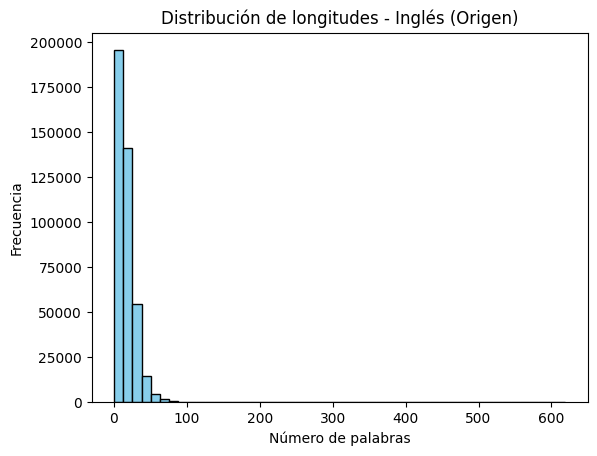

In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################

# Plot Source language
import matplotlib.pyplot as plt

# Calculamos la longitud (número de palabras) de cada frase en inglés
en_lengths = [len(pair[0].split()) for pair in data]

# Graficamos
plt.hist(en_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de longitudes - Inglés (Origen)')
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.savefig('hist_en.png')

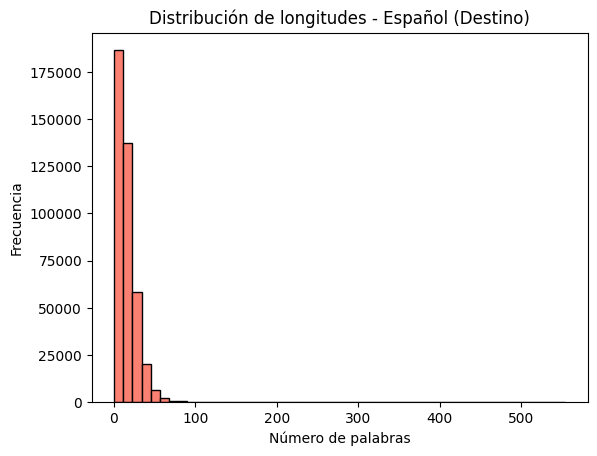

In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################

# Plot Target language
# Calculamos la longitud de cada frase en español
es_lengths = [len(pair[1].split()) for pair in data]

# Graficamos
plt.hist(es_lengths, bins=50, color='salmon', edgecolor='black')
plt.title('Distribución de longitudes - Español (Destino)')
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.savefig('hist_es.png')

**d. Calcular el vocabulario tanto en el idioma origen , como en el idioma destino, e imprimir su tamaño**.

*Resultado esperado:*
* Se visualizarán dos números. Cada número representa el tamaño del vocabulario de las frases del idioma origen y del destino, respectivamente, después de haber aplicado el preprocesamiento y tokenización.
* Lista de los 10 primeros tokens de cada idioma.

In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################

#  set para identificar palabras únicas de forma eficiente
vocab_en = set()
for pair in data:
    for word in pair[0].split():
        vocab_en.add(word)

vocab_es = set()
for pair in data:
    for word in pair[1].split():
        vocab_es.add(word)

#  resultados de tamaño
print(f"Tamaño del vocabulario en Inglés (Origen): {len(vocab_en)} palabras únicas.")
print(f"Tamaño del vocabulario en Español (Destino): {len(vocab_es)} palabras únicas.")

# muestra de los 10 primeros tokens encontrados
# Nota: Los sets no tienen orden, así que la muestra será aleatoria
print("\nMuestra de los 10 primeros tokens en Inglés:")
print(list(vocab_en)[:10])

print("\nMuestra de los 10 primeros tokens en Español:")
print(list(vocab_es)[:10])

Tamaño del vocabulario en Inglés (Origen): 84070 palabras únicas.
Tamaño del vocabulario en Español (Destino): 120033 palabras únicas.

Muestra de los 10 primeros tokens en Inglés:
['unlocking', 'intermesh', 'furstenberg', 'powering', 'anticommunist', 'virologists', 'chriss', 'recurrent', 'juansharks', 'intensely']

Muestra de los 10 primeros tokens en Español:
['rocknroll', 'genéricas', 'metodista', 'escarcha', 'onu', 'furstenberg', 'preferirán', 'otorgado', 'cerillas', 'juansharks']


**e. Separamos los conjuntos de entrenamiento por idioma y los codificamos.**

En este paso, se separarán los datos en dos conjuntos: uno para entrenamiento (llamado *train*) y otro para prueba (llamado *test*), utilizando una división del 80% para entrenamiento y 20% para prueba.


*Salida esperada:* tres primeras filas del dataset de entrenamiento *train*.


In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################

from sklearn.model_selection import train_test_split

#  train (80%) y test (20%)
#  random_state para que la división sea siempre la misma
train, test = train_test_split(data, test_size=0.2, random_state=42)

print(f"Tamaño del dataset de entrenamiento (train): {len(train)}")
print(f"Tamaño del dataset de prueba (test): {len(test)}")

print("\nMuestra de las 3 primeras filas del dataset de entrenamiento (train):")
for i in range(3):
    print(f"{i+1}. EN: {train[i][0]}")
    print(f"   ES: {train[i][1]}")

Tamaño del dataset de entrenamiento (train): 330308
Tamaño del dataset de prueba (test): 82577

Muestra de las 3 primeras filas del dataset de entrenamiento (train):
1. EN: so lets do a little experiment together
   ES: así que hagamos un pequeño experimento juntos
2. EN: industry will not agree to increased regulation unless it believes this will stave off even more regulation or perhaps knock some competitors out of the market
   ES: la industria no acordará incrementar las regulaciones a no ser que piense que esto evitará aún más regulaciones o que tal vez elimine algunos competidores del mercado
3. EN: you can do things that you cannot see with your eyes
   ES: pueden hacer cosas que no pueden ver con sus ojos


**f. Definir y aplicar una función para codificar las secuencias**

En este paso, los dos conjuntos de datos creados en el punto anterior,  serán codificados usando **tokenización** y un proceso de **padding** para asegurar que todas las secuencias, de un mismo idioma, tienen la misma longitud.

**Importante:** Para llevar a cabo un primer experimento, *dependiendo de la capacidad de procesamiento disponible para cada uno*, se sugiere ajustar el valor del parámetro **longitud de secuencia**, *hasta encontrar el valor más alto posible que, permita entrenar el modelo encoder-decoder, en un tiempo aceptable.*

El parámetro **longitud de secuencia** tiene un impacto importante en el entrenamiento del modelo. Un valor alto permite al modelo capturar más contexto en las frases, lo cual es crucial para traducir correctamente oraciones complejas; sin embargo, si la longitud es demasiado corta, el modelo puede truncar frases importantes, perdiendo información clave. Uso de memoria y eficiencia computacional:

Además, longitudes mayores requieren más memoria, ya que el modelo debe manejar matrices más grandes para representar las secuencias. Mientras que, longitudes cortas son más eficientes en términos de recursos, pero pueden sacrificar precisión si las oraciones reales exceden ese límite con frecuencia.

Finalmente, en traducción automática, las longitudes de las secuencias en el idioma origen y destino no siempre deben ser iguales (por ejemplo, una oración en inglés puede ser más corta que su equivalente en alemán).

Considerando lo anterior, si se dispone de infraestructura con GPU, se sugiere iniciar con un valor máximo de 12 (o cercano) y mínimo de 4.

Si durante el entrenamiento, se presentan problemas (por limitación de infraestructura), se podría volver a este paso para fijar el valor mínimo de 4 para la longitud de secuencia de ambos idiomas, aunque, los resultados de la traducción serían pobres.


**Salida esperada:** Tamaño de cada dataset y muestra de las tres primeras secuencias codificadas del dataset de entrenamiento.

In [ ]:
##############################################
# SOLUCIÓN                                  #
#############################################

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#  Función para crear y entrenar el tokenizador
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# Preparar los tokenizadores basándonos en todo el dataset para cubrir todo el vocabulario
en_tokenizer = create_tokenizer([pair[0] for pair in data])
es_tokenizer = create_tokenizer([pair[1] for pair in data])

# Guardar los tamaños de los vocabularios (+1 para el token de padding '0')
en_vocab_size = len(en_tokenizer.word_index) + 1
es_vocab_size = len(es_tokenizer.word_index) + 1

#. Función para codificar las frases y aplicar el padding
def encode_sequences(tokenizer, length, lines):
    # Convertimos el texto a secuencias de números
    seq = tokenizer.texts_to_sequences(lines)
    # Aplicamos el padding (post: rellena con ceros al final de la frase)
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

# codificar los datos de entrenamiento
trainX = encode_sequences(en_tokenizer, max_text_length, [pair[0] for pair in train])
trainY = encode_sequences(es_tokenizer, max_text_length, [pair[1] for pair in train])

# codificar los datos de prueba
testX = encode_sequences(en_tokenizer, max_text_length, [pair[0] for pair in test])
testY = encode_sequences(es_tokenizer, max_text_length, [pair[1] for pair in test])

# Resultados
print(f"Tamaño vocabulario Inglés (indices): {en_vocab_size}")
print(f"Tamaño vocabulario Español (indices): {es_vocab_size}")
print(f"Forma de trainX: {trainX.shape}")
print(f"Forma de trainY: {trainY.shape}")

print("\nMuestra de las 3 primeras secuencias codificadas (Inglés):")
print(trainX[:3])


Tamaño vocabulario Inglés (indices): 84071
Tamaño vocabulario Español (indices): 120034
Forma de trainX: (330308, 8)
Forma de trainY: (330308, 8)

Muestra de las 3 primeras secuencias codificadas (Inglés):
[[  14  202   33    5  124  862  175    0]
 [ 533 5714   75 6661   55    4    1  671]
 [  92    6   10  583   67   21   57  556]]


### 1.1.2 Definición del modelo encoder-decoder y entrenamiento (2 puntos)

**a. Definimos el modelo *encoder-decoder* basándonos en el notebook visto en la asignatura**, y lo instanciamos con una capa de embedding para las frases de la **lengua origen** y la dimensión de la última capa como el vocabulario de la **lengua destino**.

**Importante:** Para la definición del modelo, considerar los siguientes parámetros y valores referenciales:

* Como cantidad de **units** trabajar, inicialmente, con el valor de 512. El número de unidades o celdas de memoria en cada capa LSTM define la dimensionalidad del espacio interno en el que la LSTM procesa y representa la información a lo largo del tiempo; es decir, es el tamaño del vector de estado oculto *hidden state* y del estado de celda *cell state* que la LSTM mantiene para capturar patrones y dependencias en las secuencias de entrada.

* A mayor número de units, aumenta la capacidad del modelo para modelar relaciones complejas y dependencias a largo plazo en el texto, lo cual es clave en traducción automática donde el contexto puede abarcar varias palabras o frases. Sin embargo, un valor alto incrementa el número de parámetros, por tanto, se requerirá más memoria y tiempo de cómputo; además, crece el riesgo de sobreajuste si los datos de entrenamiento no son suficientes.

* Longitud de los vectores de embeddings *embedding_vec_length* establecer en 200; este es un valor referencial que podría ser ajustado según el tamaño del vocabulario, la complejidad del idioma y los recursos disponibles. Más adelante, en el *ejercicio 1.1.3* se pedirá jugar un poco con este valor.

**Resultado esperado:** se habrá instanciado un modelo encoder-decoder. Este modelo está diseñado para procesar y traducir textos del **idioma origen** al **idioma destino** utilizando capas de embedding y LSTM.

*Salida esperada*: Utilizar el método *mt_model.summary()* para visualizar la estructura y configuración del modelo, incluyendo el número de parámetros y la disposición de las capas.

In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, RepeatVector, TimeDistributed

def define_model(en_vocab, es_vocab, en_timesteps, es_timesteps, n_units, embedding_dim):
    model = Sequential()

    # ENCODER
    # La capa de Embedding convierte los índices numéricos en vectores densos
    model.add(Embedding(en_vocab, embedding_dim, input_length=en_timesteps, mask_zero=True))
    # La LSTM del encoder captura el "significado" de la frase origen
    model.add(LSTM(n_units))

    # El RepeatVector actúa como puente, repitiendo el vector de contexto del encoder
    model.add(RepeatVector(es_timesteps))

    #  DECODER
    # La LSTM del decoder genera la secuencia en el idioma destino
    model.add(LSTM(n_units, return_sequences=True))
    # TimeDistributed aplica una capa densa a cada paso de tiempo de la secuencia
    model.add(TimeDistributed(Dense(es_vocab, activation='softmax')))

    return model

# Instanciar el modelo con los valores de tu dataset
# Usamos max_text_length para ambos timesteps según las instrucciones
mt_model = define_model(en_vocab_size, es_vocab_size, max_text_length, max_text_length, units, embedding_vec_length)

# Visualizamos estructura
mt_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**b. Compilamos el modelo**

**Resultado esperado:** el modelo estará compilado y listo para ser entrenado. Se tiene que utilizar el optimizador *RMSprop* con una tasa de aprendizaje de *0.001* y la función de pérdida *sparse_categorical_crossentropy*.

In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################


from tensorflow.keras.optimizers import RMSprop

# Compilar con los parámetros solicitados
mt_model.compile(optimizer=RMSprop(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

print("Modelo compilado con éxito.")

Modelo compilado con éxito.


**c. Entrenamos y guardamos el modelo.**

**Importante:** El modelo puede tardar horas si se hace en CPU, y requerirá mucho menos si existen GPUs disponibles. Colab permite el uso de GPU en general, si no se hace un uso extensivo, y se va deshabilitando la opción y habilitando segun necesidades. Si se tiene activada siempre penaliza y la desactiva.

* Por tanto, para probar si funciona, recomendamos lanzar el entrenamiento **solo con una época** y ver que funciona. Una vez tenemos claro que el flujo está funcionando, subimos el valor (por ejemplo, 50 o 100, dependiendo cómo evoluciona el modelo con cada *epoch*).

* Si, durante el entrenamiento, Colab no puede cargar el modelo en memoria, recomendamos bajar el valor de **longitud de palabra** a 4 y el número de **units** a 128, de esta manera podríamos completar el proceso, aunque, seguramente, los resultados no serán buenos.

* Revisar el `Notebook de Ejemplo`, en el que se proporcionan pautas y guías para llevar un mejor control de las ejecuciones cuando ocurren reinicios de sesión o saturación de memoria.

*Resultado esperado*
* Path de la carpeta donde se ubicará el *best-model*
* Gràfica validation_loss/training_loss

In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

# Definimos la ruta para guardar el modelo
# Asegúrate de que el directorio 'TA/model' exista en tu Drive
path_model = "/content/drive/MyDrive/TA/model/model_ta_en_es.keras"

# Callbacks
checkpoint = ModelCheckpoint(path_model, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Entrenamiento de prueba (1 sola época)
# Usamos un subconjunto o valid_split para monitorear el progreso
history = mt_model.fit(trainX, trainY,
                      epochs=1, # Cambia a 50 o 100 después de esta prueba
                      batch_size=batch_size,
                      validation_split=0.2,
                      callbacks=[checkpoint, early_stop],
                      verbose=1)



4129/4129 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.1163 - loss: 7.2207
Epoch 1: val_loss improved from inf to 6.72855, saving model to /content/drive/MyDrive/TA/model/model_ta_en_es.keras
4129/4129 ━━━━━━━━━━━━━━━━━━━━ 1146s 275ms/step - accuracy: 0.1163 - loss: 7.2206 - val_accuracy: 0.1453 - val_loss: 6.7286


### 1.1.3 Predecir

**a. Generar predicciones.**

Una vez entrenado el modelo, aplicar el método *predict()* al conjunto de test para obtener las prediciones.

**Sugerencia:**

- Revisar el `Notebook de Ejemplo`, en el que proporciona una pauta para trabajar con un subconjunto del dataset de test, en caso de tener limitaciones durante el procesamiento.

*Resultado esperado*
* shape de las raw predictions (raw_preds) i
* shape predictions (preds)
* print de las dos primeras predicciones

In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################

import numpy as np

#  muestra del conjunto de test para no saturar la memoria
testX_sample = testX[:100]

#  predicciones (raw_preds)
# Esto nos devolverá una probabilidad para cada palabra del vocabulario
raw_preds = mt_model.predict(testX_sample, verbose=1)

#  índice de la palabra con mayor probabilidad (preds)
preds = np.argmax(raw_preds, axis=-1)

# Resultados
print(f"\nShape de las raw predictions: {raw_preds.shape}")
print(f"Shape de las predictions: {preds.shape}")

print("\nÍndices de las dos primeras predicciones:")
print(f"Pred 1: {preds[0]}")
print(f"Pred 2: {preds[1]}")



4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step

Shape de las raw predictions: (100, 8, 120034)
Shape de las predictions: (100, 8)

Índices de las dos primeras predicciones:
Pred 1: [2 2 1 1 1 1 0 0]
Pred 2: [4 1 1 1 1 1 1 0]


**b. Visualización de resultados.**

Visualizamos los resultados de las predicciones con los valores esperados.

**Resultado esperado:** predicciones traducidas de las primeras 10 entradas del conjunto de prueba. Estas predicciones serán mostradas junto a los textos esperados para comparar.


In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################
#  mapear un índice a su palabra correspondiente
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

#  convertir la secuencia de índices en una frase
def decode_sequence(prediction, tokenizer):
    words = []
    for i in prediction:
        if i == 0: # Saltamos el padding
            continue
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        words.append(word)
    return ' '.join(words)

#  primeros 10 resultados del subconjunto de test
print(f"{'FUENTE (EN)':<50} | {'REAL (ES)':<50} | {'PREDICCIÓN (ES)'}")
print("-" * 140)

for i in range(10):
    source_text = test[i][0]
    real_text = test[i][1]
    predicted_text = decode_sequence(preds[i], es_tokenizer)

    # Formatear  la salida para que sea legible
    print(f"{source_text[:50]:<50} | {real_text[:50]:<50} | {predicted_text}")


FUENTE (EN)                                        | REAL (ES)                                          | PREDICCIÓN (ES)
--------------------------------------------------------------------------------------------------------------------------------------------
and so one kind of information space that i take i | un espacio de donde tomo inspiración es mi escrito | que que de de de de
meditweet is an intelligent twitter bot that helps | meditweet es un bot de twitter inteligente que ayu | la de de de de de de
and that really gives them a handle on a world in  | y eso en realidad es les da un control en un mundo | que que que que que de la
but i think were a lot closer to erring on the sid | pero creo que estamos mucho más de cerca de errar  | la de de de de de de
you dont know this planet because most of its cove | no conocemos este planeta porque la mayor parte es | que de de de de de la
the holocaust which has the dubious distinction of | ¿el holocausto que tiene la dudosa distinció

f. **Pregunta de análisis:** Según los resultados obtenidos en la predicción (valores reales vs. valores generados), ¿Por qué creéis que no son buenos, y como creéis que podrían obtenerse mejores resultados?

**¿Por qué no son buenos?**
Porque el modelo únicamente ha visto el conjunto de datos una vez (1 epoch), lo cual es claramente insuficiente para manejar un vocabulario de unas 120.000 palabras. Además, una longitud de secuencia de solo 8 palabras resulta demasiado corta para las frases de TED, provocando que el modelo pierda gran parte del contexto necesario para realizar una traducción adecuada.

**¿Cómo mejorar?**
Se podría mejorar entrenando el modelo durante más épocas, aumentando la longitud de las secuencias (por ejemplo, a 15 o 20 palabras si la memoria lo permite) y, sobre todo, utilizando embeddings preentrenados.

**Respuesta a la pregunta**
-







### 1.1.4 Experimentación con diferentes resultados (1,5 puntos)


En este apartado, podríamos analizar cómo afecta a la calidad de la traducción, la variación de distintos parámetros del modelo, como:
* longitud de embeddings (*embedding_vec_length*),
* longitud de secuencia (*max_text_length*),
* número de units (*units*),
* batch size,
* epochs etc.

Sin embargo, debido a que no siempre encontraremos GPUs libres, aquí vamos vamos a limitarnos a experimentar con los parámetros:
* *embedding_vec_length* y
* *max_text_length*.

**Importante:** durante las ejecuciones, dependiendo del modelo y del consumo de memoria actual, la predicción se puede cancelar por agotar toda la memoria disponible. En caso de cancelación, recargar el modelo desde local (ver apartado 1.1.2.2 del `Notebook de Ejemplo`) y predecir solo para un subconjunto del fichero de test (aunque en este caso no serán válidas las magnitudes de medición de calidad del sistema).  


Además, se sugiere que tras cada entrenamiento, se realice una copia del modelo entrenado y se almacene en local *'model/..'* para, en caso de cancelación, no tener que realizar de nuevo el correspondiente entrenamiento, asociando a la copia los parámetros con los que se entrenó.


**a. Experimentar con el valor de longitud de embedding** (*embedding_vec_length*)

Analizar cómo un incremento/reducción en el tamaño de los vectores de embedding afecta el rendimiento de un modelo de traducción automática del **idioma origen** al **idioma destino**.

**Resultado esperado:** Se imprimirá el resultado que muestre el rendimiento del modelo creado para diferentes tamaños de embedding (inicialmente, se sugirió trabajar con 200; ahora, se podría experimentar con valores como 50 y 300). Cada resultado constará del tamaño del embedding seguido de un *score*, que indique la efectividad del modelo calculado con *model.evaluate()*


In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################
# Definir  tamaños a probar
embedding_sizes = [50]

for size in embedding_sizes:
    print(f"\n Entrenando modelo con Embedding Size: {size} ")

    # definir nuevo modelo con el tamaño 'size'
    model_exp = define_model(en_vocab_size, es_vocab_size, max_text_length, max_text_length, units, size)

    #  Compilar
    model_exp.compile(optimizer=RMSprop(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    #Entrenar (1 época para comparar rápido)
    model_exp.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=1)

    # Evaluar con el conjunto de test
    score = model_exp.evaluate(testX, testY, verbose=0)

    print(f"Resultado para Embedding {size}: Loss = {score[0]:.4f}, Accuracy = {score[1]:.4f}")



 Entrenando modelo con Embedding Size: 50 
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 1207s 233ms/step - accuracy: 0.1174 - loss: 7.1711
Resultado para Embedding 50: Loss = 6.7725, Accuracy = 0.1333


**b. Ejercicio opcional: Experimentar con el valor longitud de secuencia** (*max_text_length*).

Analizar cómo un incremento/reducción de la longitud de secuencia impacta a la calidad del modelo de traducción.

**Resultado esperado:** Se imprimirá el resultado que muestre el rendimiento del modelo para una longitud de secuencia superior o inferior al establecido (por ejemplo, si se inicializó el modelo preliminar con el valor de 8, aquí se podría probar con 4 y 12). El resultado constará del valor de la longitud, y del score que indica la efectividad del modelo calculado con *model.evaluate()*

In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################

# longitud de secuencia mayor (12)
new_max_length = 12

print(f"\n Experimentando con Longitud de Secuencia: {new_max_length} ")

#  Re-codificamar las secuencias con la nueva longitud (padding a 12)
trainX_12 = encode_sequences(en_tokenizer, new_max_length, [pair[0] for pair in train])
trainY_12 = encode_sequences(es_tokenizer, new_max_length, [pair[1] for pair in train])
testX_12 = encode_sequences(en_tokenizer, new_max_length, [pair[0] for pair in test])
testY_12 = encode_sequences(es_tokenizer, new_max_length, [pair[1] for pair in test])

# Definir el modelo para esta nueva longitud (usando units=512 y embedding=200)
model_len_exp = define_model(en_vocab_size, es_vocab_size, new_max_length, new_max_length, units, embedding_vec_length)

# compilar
model_len_exp.compile(optimizer=RMSprop(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# entrenar
model_len_exp.fit(trainX_12, trainY_12, epochs=1, batch_size=batch_size, verbose=1)

# Evaluar
score_len = model_len_exp.evaluate(testX_12, testY_12, verbose=0)

print(f"\nResultado para Longitud {new_max_length}: Loss = {score_len[0]:.4f}, Accuracy = {score_len[1]:.4f}")



 Experimentando con Longitud de Secuencia: 12 
5162/5162 ━━━━━━━━━━━━━━━━━━━━ 1818s 351ms/step - accuracy: 0.1928 - loss: 6.4810

Resultado para Longitud 12: Loss = 6.3161, Accuracy = 0.1741


Según los resultados obtenidos en este ejercicio 1.1.3, discutir en el *documento de Análisis* las diferencias encontradas.

## 1.2 TA con Embeddings preentrenados (2,5 puntos)

En este apartado repetiremos el ejercicio anterior cargando a la capa de embedding los pesos d'un modelo GloVe entrenado para el inglés.

Este apartado 1.2 puede ejecutarse en diferentes sesiones de trabajo y no depende de las secciones anteriores a excepción de:
* Ejecutar el apartado *0. Conexión con Drive* (o las celdas que se hayan definido para otros entornos no Colab).
* Ejecutar el apartado *Imports*
* Ejecutar el partado *1.1.0 Hiperparámetros. **IMPORTANTE** El parámetro *embedding_vec_length* ha de coincidr con la dimensión del vector de GloVe (inicialmente 300)
* Ejecutar las celda de preparación de datos (sección 1.1.1)


### 1.2.1 Carga de GloVe

**a. Empezamos cargando el modelo GloVe para el inglés.**

Podéis usar 'glove.42B.300d.txt'.(https://www.kaggle.com/datasets/yutanakamura/glove42b300dtxt)

**Salida esperada:** tamaño del objeto cargado, usar *len()*.

In [ ]:
import numpy as np

embeddings_index = {}
RUTA_GLOVE = '/content/drive/MyDrive/glove.42B.300d.txt'

print(f"Cargando vectores desde: {RUTA_GLOVE}...")

try:
    with open(RUTA_GLOVE, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            # vector de 300 dimensiones
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Carga finalizada. Se han cargado {len(embeddings_index)} palabras.")
except Exception as e:
    print(f"Error al cargar GloVe: {e}")

Cargando vectores desde: /content/drive/MyDrive/glove.42B.300d.txt...
Carga finalizada. Se han cargado 1917494 palabras.


### 1.2.2 Definición del modelo

**a. Construir la matriz de embeddings.**
  
A continuación, tenemos que construir la matriz de embeddings.

Para no cargar todo el vocabulario del modelo, podemos filtrar solo aquellas entradas presentes en el vocabulario del tokenizador que usaremos.

Además, debemos de incluir en la matriz de vectores correspondientes los índices de las entradas (palabras) que no encontremos en el modelo glove cargado. Estos vectores se suelen inicializar con 0s o con el resultado de una distribución N (0,1).

**Salida esperada:**
* Dimensión de la matriz de embeddings.
* Número de palabras que constan en GloVe y las que no constan.
* imprimir los 3 primeros elementos de la matriz de embeddings.

In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################

# La dimensión debe coincidir con el archivo GloVe (300)
embedding_dim_glove = 300
# la matriz vacía (llena de ceros)
embedding_matrix = np.zeros((en_vocab_size, embedding_dim_glove))

hits = 0
misses = 0

# Llenar la matriz con los vectores de GloVe
for word, i in en_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Palabras encontradas en GloVe
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        # Palabras no encontradas (se quedan en cero)
        misses += 1

print(f"Matriz de embeddings creada con forma: {embedding_matrix.shape}")
print(f"Palabras encontradas en GloVe: {hits}")
print(f"Palabras no encontradas (misses): {misses}")

# primeros 5 valores del primer embedding no nulo (por ej, el índice 1)
print(f"\nMuestra del primer embedding (índice 1): {embedding_matrix[1][:5]}...")

Matriz de embeddings creada con forma: (84071, 300)
Palabras encontradas en GloVe: 68500
Palabras no encontradas (misses): 15570

Muestra del primer embedding (índice 1): [-0.20838    -0.14932001 -0.017528   -0.028432   -0.060104  ]...


**b. Inicializar la capa de embeddings.**

Para inicializar una capa de embeddings con pesos predefinidos se utiliza el argumento `weights`. Además, como no queremos que se modifiquen los pesos, marcamos el argumento `trainable` como `False`.

*Resultado esperado*:

Dimensiones de la capa de Embeddings

In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################
#  longitud de secuencia del 1.1.4.b
new_max_length = 12

# capa de embedding con los pesos de GloVe
# weights=[embedding_matrix] carga vectores preentrenados
# trainable=False asegura que los pesos no cambien durante el entrenamiento
embedding_layer_glove = Embedding(
    input_dim=en_vocab_size,
    output_dim=embedding_dim_glove,
    weights=[embedding_matrix],
    input_length=new_max_length,
    trainable=False,
    mask_zero=True
)

print(f"Capa de embedding inicializada con éxito (Longitud: {new_max_length})")

Capa de embedding inicializada con éxito (Longitud: 12)


**c. Definición del nuevo modelo considerando los pesos del modelo preentrenado.**

 Implementa y entrena de nuevo un modelo de traducción automática del **idioma origen** al **idioma destino**, esta vez, cargando los pesos de la capa embedding a partir del modelo Glove preentrenado en inglés y disponible en `glove.42B.300d.txt`.

 *Solución esperada*: 'summary' de la definición del modelo.


In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

def build_model_with_glove(n_units, es_vocab, es_timesteps, embedding_layer):
    model = Sequential()
    model.add(embedding_layer) # Usamos la capa que acabamos de corregir
    model.add(LSTM(n_units))
    model.add(RepeatVector(es_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(es_vocab, activation='softmax')))
    return model

# Instanciar el modelo
mt_model_glove = build_model_with_glove(
    units,
    es_vocab_size,
    new_max_length,
    embedding_layer_glove
)

mt_model_glove.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │    25,221,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,221,300 (96.21 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 25,221,300 (96.21 MB)

d. **Compilamos el modelo**

*Solución esperada*: 'summary' de la definición del modelo.

In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################

from tensorflow.keras.optimizers import RMSprop

# Compilamos el modelo diseñado para GloVe
mt_model_glove.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Modelo con GloVe compilado con éxito.")


Modelo con GloVe compilado con éxito.


### 1.2.3 Entrenamiento del modelo

**Entrenar y guardar el modelo.**

Aunque este entrenamiento es quizá un "poco" más liviano que el anterior, recomendamos el uso de GPU si es viable.

**Sugerencias:**

- Probar con diferentes valores en *batch_size*. En el notebook de ejemplo se trabajó bien con el valor de 128.

- Observar cómo evoluciona el modelo conforme se ejecuta cada *epoch*; en caso de no observar mejoras, se puede bajar su valor. En el notebook de ejemplo, se bajó el valor a 50 porque a partir de la *epoch* 32 no se notaron diferencias.

- Revisar el `Notebook de Ejemplo`, subsección 1.2.3.2, en el que proporcionan pautas y guías para llevar un mejor control de las ejecuciones cuando ocurren reinicios de sesión o saturación de memoria.

*Resultado esperado*

* Path donde se ubicará el 'best model'
* Plot validation_loss / training_loss

In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
new_max_length = 12
trainX_12 = encode_sequences(en_tokenizer, new_max_length, [pair[0] for pair in train])
trainY_12 = encode_sequences(es_tokenizer, new_max_length, [pair[1] for pair in train])
testX_12 = encode_sequences(en_tokenizer, new_max_length, [pair[0] for pair in test])
testY_12 = encode_sequences(es_tokenizer, new_max_length, [pair[1] for pair in test])

#  carpeta 'model' en Drive
path_model_glove = "/content/drive/MyDrive/TA/model/model_ta_en_es_glove.keras"

#  Callbacks para el control del entrenamiento
checkpoint_glove = ModelCheckpoint(
    path_model_glove,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

early_stop_glove = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True
)

#  entrenamiento
history_glove = mt_model_glove.fit(
    trainX_12,
    trainY_12,
    epochs=1,
    batch_size=128,
    validation_split=0.2,
    callbacks=[checkpoint_glove, early_stop_glove],
    verbose=1
)

2065/2065 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.1818 - loss: 6.5835
Epoch 1: val_loss improved from inf to 6.09350, saving model to /content/drive/MyDrive/TA/model/model_ta_en_es_glove.keras
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 1428s 689ms/step - accuracy: 0.1818 - loss: 6.5834 - val_accuracy: 0.2020 - val_loss: 6.0935


### 1.2.4 Generación de predicciones

En este paso, aplicar el modelo para generar las predicciones utilizando el dataset de test.

**Resultado esperado:**

* Shape de las raw predictions (raw_preds) i
* Shape predictions (preds)
* Print de las dos primeras predicciones.
* Visualizar tabla de resultados: frase en idioma origen, texto traducido real vs. texto traducido generado.

**Sugerencia:** Si durante la ejecución, se cancela la predicción por agotar toda la memoria disponible, recargar el modelo desde local (ver apartado 1.2.3.2 del `Notebook de Ejemplo`) y predecir solo para un subconjunto del fichero de test (aunque en este caso no serán validas las magnitudes de medición de calidad del sistema).   

In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################

#  muestra (ej. las primeras 100 frases) del conjunto de test codificado
testX_sample = testX_12[:100]

#  Predecir
raw_preds_glove = mt_model_glove.predict(testX_sample, verbose=1)

#  índices de las palabras
preds_glove = np.argmax(raw_preds_glove, axis=-1)

# Funciones de decodificación (mismas de antes)
def decode_sequence(prediction, tokenizer):
    words = []
    for i in prediction:
        if i == 0: continue
        word = next((w for w, idx in tokenizer.word_index.items() if idx == i), None)
        if word is None: break
        words.append(word)
    return ' '.join(words)

#  resultados (primeras 10 frases)
print(f"{'FUENTE (EN)':<50} | {'REAL (ES)':<50} | {'PREDICCIÓN (GLOVE)'}")
print("-" * 140)

for i in range(10):
    source_text = test[i][0]
    real_text = test[i][1]
    predicted_text = decode_sequence(preds_glove[i], es_tokenizer)

    print(f"{source_text[:50]:<50} | {real_text[:50]:<50} | {predicted_text}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step
FUENTE (EN)                                        | REAL (ES)                                          | PREDICCIÓN (GLOVE)
--------------------------------------------------------------------------------------------------------------------------------------------
and so one kind of information space that i take i | un espacio de donde tomo inspiración es mi escrito | y y y y que que que que que que que
meditweet is an intelligent twitter bot that helps | meditweet es un bot de twitter inteligente que ayu | y y y y y y y y y y y y
and that really gives them a handle on a world in  | y eso en realidad es les da un control en un mundo | y que que que que que que que que que
but i think were a lot closer to erring on the sid | pero creo que estamos mucho más de cerca de errar  | y que que que que que y
you dont know this planet because most of its cove | no conocemos este planeta porque la mayor parte es | en en en y y y en en en en en en
the holoca

# 2. Detección de NER y NEL (3 puntos)



En esta segunda parte, nos enfocaremos en la detección de entidades nombradas (NER).

Además, haremos Named Entity Linking (NEL) para buscar entidades enlazadas a una base de conocimiento (KB), en este caso la Wikidata. Encontraremos los enlaces a Wikidata de ciertas entidades de un texto, utilizando la API de Wikidata.

Este apartado puede ejecutarse aisladamente y no depende del apartado anterior, a excepción de ejecutar el apartado *0. Conexión con Drive* (o las celdas que se hayan definido para otros entornos no Colab).

## 2.1 Detección de NER (2 puntos)

En esta primera subsección, detectaremos entidades nombradas, utilizando tanto spaCy como transformers.


### 2.1.1 Detección de entidades nombradas (NER) usando spaCy.

Para detectar NER usaremos el modelo `en_core_web_sm` de spaCy.

**a. Instalar librerías y modelo de lenguaje a usar.**

In [ ]:
!pip install spacy numpy

In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 58.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


**Importante:**

Si la descarga de *'en_core_web_sm'* se realiza desde Google Colab y tras la descarga, aparece el mensaje 'Restart to reload dependencies', entonces, ejecutar la opción de menú 'Runtime>>>Restart session'. A continuación volver a ejecutar la sección 0 de este notebook.

**b. Definir funciones para imprimir los resultados de la detección.**

In [ ]:
def get_tokens_to_print(model, text):
  """Print tokens of the text and its relevant attributes.

    Parameters:
      model (spaCy model): spaCy model used for tokenization
      text (str):  text to transform in a spaCy doc class.

    Returns: ---
  """
  doc = model(text)
  print (f"The text:\n\n{get_text_to_print(text)}\n\nwas converted in a spaCy object: {type(doc)}\n")
  print (f"Token-based analysis. Each token is a spaCy object: {type(doc[0])}\n")

  # We obtain rows to print: headers and content
  rows  = []
  # head_align: List of tuples. Each tuple: heather and its alignment when printing
  head_align  = [('Token', '<'), ('Lemma', '<'), ('Syntactic parent', '<'), ('#Tok', '>'), ('Chr_Start', '>'), ('Chr_End', '>'), ('POS', '<'),
                 ('TAG', '<'), ('TAG meaning:', '<'), ('ENT', '<'), ('DEP', '<'), ('DEP meaning:', '<')]
  head, align = list(zip(*head_align))
  rows.append(head)                           # Header
  rows.append(['='*len(i) for i in head])     # Underline headers
  for tok in doc:
    rows.append([tok.text, tok.lemma_, tok.head.text, str(tok.i), str(tok.idx), str(tok.idx+len(tok)-1), tok.pos_,
                 tok.tag_, str(spacy.explain(tok.tag_))[:20], tok.ent_type_, tok.dep_, str(spacy.explain(tok.dep_))[:20]])

  # Width of each column: the witdh of the longest element
  columns       = zip(*rows)
  column_widths = [max(len(i) for i in col) for col in columns]

  # Print the files with alignment
  for row in rows:
    print(*[f"{row[i]:{align[i]}{column_widths[i]}}  " for i in range(0, len(row))])

In [ ]:
def get_text_to_print(text):
  """Format given text.

    Parameters:
      text (str): text to print

    Returns:
      str: text formatted in 100 character lines with an initial line numbering the characters
  """
  line_length = 100
  line_poss   = "     1-------10--------20--------30--------40--------50--------60--------70--------80--------90-------100"
  text        = text.replace("\n", " ")     # In order to avoid that the \n character produces a line change.
  text        = text.replace("\r", " ")     # In wikipedia texts we have detected the character '\r' that, if interpreted, may induce some printing problems.
  text_format = "\n".join([ f"{i//line_length:<5}{text[i:i+line_length]}"  for i in range(0, len(text), line_length) ])
  return line_poss + "\n" + text_format + "\n" + line_poss

**c. Cargar el modelo `en_core_web_sm`**

**Resultado esperada**: Código para la carga del modelo.

In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################

import spacy

# Cargamos el modelo pequeño de inglés
nlp = spacy.load("en_core_web_sm")

print("Modelo 'en_core_web_sm' cargado correctamente.")

Modelo 'en_core_web_sm' cargado correctamente.


**d. Convertir un texto en objecto `Doc` de spaCy.**

Para realizar la detección de entidades nombradas, proponer un texto en inglés que mencione a entidades de diferente tipo.


**Salida Esperada**: Visualizar los resultados de analizar el texto propuesto a nivel de cada POS.

**Sugerencia:** Para la visualización se puede utilizar la función *get_tokens_to_print()*, previamente creada, o *displacy.render()* de spaCy.

In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################

text_ner = """
LeBron James scored 30 points for the Los Angeles Lakers last night in California.
Lionel Messi moved to Inter Miami in 2023 and has attracted thousands of fans to Florida.
FC Barcelona remains one of the most successful football clubs in Spain.
"""

# Analizamos el texto y visualizamos los tokens con la función definida antes
get_tokens_to_print(nlp, text_ner)

The text:

     1-------10--------20--------30--------40--------50--------60--------70--------80--------90-------100
0     LeBron James scored 30 points for the Los Angeles Lakers last night in California. Lionel Messi mov
1    ed to Inter Miami in 2023 and has attracted thousands of fans to Florida. FC Barcelona remains one o
2    f the most successful football clubs in Spain. 
     1-------10--------20--------30--------40--------50--------60--------70--------80--------90-------100

was converted in a spaCy object: <class 'spacy.tokens.doc.Doc'>

Token-based analysis. Each token is a spaCy object: <class 'spacy.tokens.token.Token'>

Token        Lemma        Syntactic parent   #Tok   Chr_Start   Chr_End   POS     TAG    TAG meaning:           ENT        DEP        DEP meaning:          
=====        =====        ================   ====   =========   =======   ===     ===    ============           ===        ===        ============          

            
            LeBron            

### 2.1.2 Entrenar un nuevo modelo de NER con el corpus de detección de entidades escogido.

**a. Convertir el corpus elegido al formato que entiende spaCy.**

*Sugerencia:* Si el corpus es grande, y el entrenamiento está tardando demasiado, puedes generar una versión más reducida de todos los ficheros del corpus elegido (train, dev y test). La reducción estaría bien de hacerla del 25%.

Recuerda que spaCy contiene funciones que permiten convertir formatos como *conll* al formato compilado que necesita el módulo de train de spaCy.

**Salida esperada:** Código para convertir el corpus training (train.txt) y el de validacion (valid.txt), del formato origen a spaCy.

In [ ]:


import os


ruta_ner = "/content/drive/MyDrive/NER/"

if not os.path.exists(ruta_ner):
    os.makedirs(ruta_ner)


!wget -O {ruta_ner}train.txt https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train
!wget -O {ruta_ner}valid.txt https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
!wget -O {ruta_ner}test.txt https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testb

print(f"\n Archivos descargados en: {ruta_ner}")
print(f"Contenido actual: {os.listdir(ruta_ner)}")

--2026-01-17 18:17:08--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3281528 (3.1M) [text/plain]
Saving to: ‘/content/drive/MyDrive/NER/train.txt’

/content/drive/MyDr 100%[===================>]   3.13M  9.67MB/s    in 0.3s    

2026-01-17 18:17:09 (9.67 MB/s) - ‘/content/drive/MyDrive/NER/train.txt’ saved [3281528/3281528]

--2026-01-17 18:17:10--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting

In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################
def convert_ner_corpus(path_ner, file_list):
    """Convierte archivos de texto (CoNLL/IOB) al formato binario .spacy.

    Parameters:
      path_ner (str): Ruta de la carpeta NER en Drive.
      file_list (list): Lista con los nombres de los archivos a convertir (ej. ['train', 'valid']).

    Returns: ---
    """
    print(f"Explorando directorio: {path_ner}\n")

    #  Verificación de seguridad: ¿Existe la carpeta?
    if not os.path.exists(path_ner):
        try:
            os.makedirs(path_ner)
            print(f" [INFO] Carpeta creada correctamente: {path_ner}")
        except OSError as e:
            print(f" [ERROR] No se pudo crear la carpeta: {e}")
            return

    # Listado de archivos para diagnóstico
    found_files = os.listdir(path_ner)
    print(f" Archivos detectados en Drive: {found_files}")

    #  Proceso de conversión
    for file_name in file_list:
        full_input_path = os.path.join(path_ner, f"{file_name}.txt")

        if f"{file_name}.txt" in found_files:
            print(f"\n Convirtiendo: {file_name}.txt ")
            try:
                # Ejecutamos el comando de spaCy para convertir el formato
                !python -m spacy convert {full_input_path} {path_ner} --converter ner
                print(f" [OK] Conversión finalizada para {file_name}")
            except Exception as e:
                print(f" [ERROR] Falló la conversión de {file_name}: {e}")
        else:
            print(f"\n [ADVERTENCIA] El archivo '{file_name}.txt' NO está en la carpeta.")
            print(f"  Sube '{file_name}.txt'  a {path_ner}")

# Definimos la ruta y los archivos según tu configuración
RUTA_NER = "/content/drive/MyDrive/NER"
ARCHIVOS_A_PROCESAR = ["train", "valid"]

# Ejecutamos la función de conversión
convert_ner_corpus(RUTA_NER, ARCHIVOS_A_PROCESAR)

Explorando directorio: /content/drive/MyDrive/NER

 Archivos detectados en Drive: ['config.cfg', 'output_ner', 'output', 'valid.txt', 'train.txt', 'train.spacy', 'test.txt', 'valid.spacy', 'test.spacy']

 Convirtiendo: train.txt 
ℹ Auto-detected token-per-line NER format
⚠ Document delimiters found, automatic document segmentation with `-n`
disabled.
✔ Generated output file (946 documents):
/content/drive/MyDrive/NER/train.spacy
 [OK] Conversión finalizada para train

 Convirtiendo: valid.txt 
ℹ Auto-detected token-per-line NER format
⚠ Document delimiters found, automatic document segmentation with `-n`
disabled.
✔ Generated output file (216 documents):
/content/drive/MyDrive/NER/valid.spacy
 [OK] Conversión finalizada para valid


**b. Descargar el modelo `en_core_web_trf`**.

In [ ]:
!python -m spacy download en_core_web_trf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.9/237.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 734.0/734.0 kB 26.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


**Importante:** En Google Colab, si tras la descarga del modelo `en_core_web_trf` aparece el mensaje 'Restart to reload dependencies', deberá ejecutarse la opción de menú 'Runtime>>>Restart session'. Luego, para mayor seguridad, volver a ejecutar la sección 0 de este notebook.

In [ ]:
!python -m spacy info en_core_web_trf


=================== Info about pipeline 'en_core_web_trf' ===================

lang                en                            
name                core_web_trf                  
version             3.8.0                         
description         English transformer pipeline (Transformer(name='roberta-base', piece_encoder='byte-bpe', stride=104, type='roberta', width=768, window=144, vocab_size=50265)). Components: transformer, tagger, parser, ner, attribute_ruler, lemmatizer.
author              Explosion                     
email               contact@explosion.ai          
url                 https://explosion.ai          
license             MIT                           
spacy_version       >=3.8.0,<3.9.0                
spacy_git_version   5010fcbd3                     
vectors             {'width': 0, 'vectors': 0, 'keys': 0, 'name': None}
pipeline            ['transformer', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']
components          ['transformer', 't

In [ ]:
!python -m spacy validate

✔ Loaded compatibility table

================ Installed pipeline packages (spaCy v3.8.11) ================
ℹ spaCy installation: /usr/local/lib/python3.12/dist-packages/spacy

NAME              SPACY            VERSION                            
en_core_web_trf   >=3.8.0,<3.9.0   3.8.0   ✔
en_core_web_sm    >=3.8.0,<3.9.0   3.8.0   ✔



In [ ]:
import spacy
print (f"Spacy version installed: {spacy.__version__}")

Spacy version installed: 3.8.11


**c. Verificar si se puede usar GPU**

Si estamos con una GPU, el parámetro gpu-id será 0. Con este cambio, spaCy utilizará la GPU y se acelerará mucho el tiempo de entrenamiento.

In [ ]:
import torch
if torch.cuda.is_available():
    gpu_id = 0    # Use the first available GPU
    print(f"Using GPU {gpu_id}")
else:
    gpu_id = -1   # Use CPU
    print("Using CPU")

Using GPU 0


**d. Entrenar el modelo `en_core_web_trf` usando la función train de spaCy.**


SpaCy realiza el entrenamiento del modelo de acuerdo con los parámetros del fichero de configuración 'config.cfg'. Una descripción de las secciones de esta configuración la puedes encontrar en: https://spacy.io/usage/training#config; describe algún cambio que realizarías si crees que puede mejorar el entrenamiento.

Además, considera que en el fichero 'config.cfg' no se determina un número prefijado de *epochs* (ver sección [training] del fichero). El criterio para finalizar viene determinado por los parámetros *max_steps* (20000) y *patience* (1600). Es decir el entrenamiento finalizaría si se cumple una de las condiciones:
* al cabo de 20000 'batches' procesados
* o bien tras 1600 'batches' procesados, no ha habido mejora en el modelo.

Por restricciones de tiempo (o por no consumir las *compute unit* disponibles en Google Colab), si se observa que tras varias iteraciones (por ejemplo a partir de la tercera iteración) el modelo ha ido mejorando (columna SCORE) y tiene un valor superior a 0.9, interrumpir manualmente el proceso. El 'best model' hasta esa iteración se encontrará en el path '{my_path_pra2}/NER/output_ner/model-best'. Este modelo es el que se podrá utilizar para validar o predecir.

In [ ]:

!python -m spacy download en_core_web_lg

print("\n[OK] Modelo 'en_core_web_lg' instalado. ")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 5.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.

[OK] Modelo 'en_core_web_lg' instalado. 


In [ ]:
# archivo de configuración base para NER con Transformers (GPU)
!python -m spacy init config /content/drive/MyDrive/NER/config.cfg --lang en --pipeline ner --optimize accuracy --gpu
print(" Archivo config.cfg generado con éxito en /NER/")


✘ The provided output file already exists. To force overwriting the
config file, set the --force or -F flag.

 Archivo config.cfg generado con éxito en /NER/


In [ ]:
# Training

path_config = "/content/drive/MyDrive/NER/config.cfg"
path_train  = "/content/drive/MyDrive/NER/train.spacy"
path_valid  = "/content/drive/MyDrive/NER/valid.spacy"
path_output = "/content/drive/MyDrive/NER/output"

#  active_gpu sea un número (0 para GPU, -1 para CPU)

try:
    print(f"Usando GPU ID: {active_gpu}")
except NameError:
    active_gpu = 0

print(" Iniciando el entrenamiento del modelo Transformer...\n")

!python -m spacy train $path_config \
    --output $path_output \
    --paths.train $path_train \
    --paths.dev $path_valid \
    --gpu-id $active_gpu

print(f"\n[FIN] Entrenamiento completado. El modelo se encuentra en: {path_output}/model-best")

 Iniciando el entrenamiento del modelo Transformer...

ℹ Saving to output directory: /content/drive/MyDrive/NER/output
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00    128.50    0.49    0.82    0.35    0.00
  0     200        830.00   9397.02   66.15   67.44   64.91    0.66
  0     400       1582.68   6002.51   74.60   75.57   73.66    0.75
  0     600        109.43   2692.11   76.96   77.93   76.02    0.77
  0     800         75.62   1888.92   83.83   85.21   82.50    0.84
  1    1000        104.24   1848.67   85.50   86.71   84.33    0.86
  1    1200        118.58   1294.51   83.35   83.05   83.64    0.83
  1    1400   

**e. Predicción de un texto de ejemplo (inferencia con el modelo entrenado).**

Cargar el mejor modelo entrenado y utilizarlo para predecir una frase de ejemplo. Recordar que, si el modelo está ya entrenado y guardado en directorio local es mejor, al iniciar una nueva sesión, recuperar la mejor versión entrenada desde local.

**Resultado esperado:** visualizar los resultados de la predicción de la variable `text`.


In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################

text = """\
Next Tuesday, Ana plans to travel to London to start her new job at Google. \
Apple announced earnings of $5 billion from iPhone sales in Cupertino.\
Jules Verne visited the Eiffel Tower while he was in Paris.\
"""




In [ ]:
# ruta del mejor modelo guardado en Drive
path_best_model = "/content/drive/MyDrive/NER/output/model-best"

print(f"Cargando el mejor modelo desde: {path_best_model}...")

try:
    # cargar modelo
    # spacy.load para recuperar la arquitectura Transformer y sus pesos
    nlp_trained = spacy.load(path_best_model)
    print(" Modelo cargado con éxito. Listo para inferencia.\n")

    # texto de ejemplo (variable 'text')

    #  Visualización de resultados con TU función personalizada
    # Esta función usará el modelo nlp_trained para analizar la variable 'text'
    get_tokens_to_print(nlp_trained, text)

except OSError:
    print(f" ERROR: No se pudo encontrar el modelo en {path_best_model}.")
    print("Asegurar de que la ruta sea correcta y el entrenamiento haya finalizado.")

Cargando el mejor modelo desde: /content/drive/MyDrive/NER/output/model-best...
 Modelo cargado con éxito. Listo para inferencia.

The text:

     1-------10--------20--------30--------40--------50--------60--------70--------80--------90-------100
0    Next Tuesday, Ana plans to travel to London to start her new job at Google. Apple announced earnings
1     of $5 billion from iPhone sales in Cupertino.Jules Verne visited the Eiffel Tower while he was in P
2    aris.
     1-------10--------20--------30--------40--------50--------60--------70--------80--------90-------100

was converted in a spaCy object: <class 'spacy.tokens.doc.Doc'>

Token-based analysis. Each token is a spaCy object: <class 'spacy.tokens.token.Token'>

Token       Lemma   Syntactic parent   #Tok   Chr_Start   Chr_End   POS   TAG   TAG meaning:   ENT   DEP   DEP meaning:  
=====       =====   ================   ====   =========   =======   ===   ===   ============   ===   ===   ============  
Next                Next 

/usr/local/lib/python3.12/dist-packages/spacy/glossary.py:20: UserWarning: [W118] Term '' not found in glossary. It may however be explained in documentation for the corpora used to train the language. Please check `nlp.meta["sources"]` for any relevant links.
  warnings.warn(Warnings.W118.format(term=term))


**f. Evaluar los resultados obtenidos y calcular las métricas.**

**Salida Esperada**: Cálculo de las métricas utilizando los datos de prueba.

**Importante:** Antes del cálculo de las métricas, no olvidar convertir el formato del archivo test.txt al formato que entiende spaCy.

In [ ]:
#Usar GPU de ser posible:

import torch
if torch.cuda.is_available():
    gpu_id = 0
    print(f"Using GPU {gpu_id}")
else:
    gpu_id = -1   # Us CPU
    print("Using CPU")

Using GPU 0


In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################
def prepare_test_data(path_ner):
    """Convierte el archivo test.txt al formato binario .spacy.

    Parameters:
      path_ner (str): Ruta de la carpeta NER en Drive.
    """
    input_test = os.path.join(path_ner, "test.txt")

    if os.path.exists(input_test):
        print(f" Convirtiendo archivo de test: test.txt ")
        #  conversor de spaCy
        !python -m spacy convert {input_test} {path_ner} --converter ner
        print(f" [OK] Archivo 'test.spacy' generado correctamente.")
    else:
        print(f" [ERROR] No se encontró 'test.txt' en {path_ner}. Verifica la descarga.")

# Ejecutar la conversión
prepare_test_data("/content/drive/MyDrive/NER")


 Convirtiendo archivo de test: test.txt 
ℹ Auto-detected token-per-line NER format
ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.
✔ Generated output file (3684 documents):
/content/drive/MyDrive/NER/test.spacy
 [OK] Archivo 'test.spacy' generado correctamente.


In [ ]:
#  rutas necesarias
path_model_best = "/content/drive/MyDrive/NER/output/model-best"
path_test_spacy = "/content/drive/MyDrive/NER/test.spacy"

#  ID de la GPU para acelerar la evaluación si está disponible
try:
    gpu_to_use = active_gpu
except NameError:
    gpu_to_use = 0

print(" Calculando métricas en el conjunto de prueba (TEST)...\n")

#  evaluación oficial de spaCy
!python -m spacy evaluate $path_model_best $path_test_spacy --gpu-id $gpu_to_use

print("\n[FIN] Evaluación finalizada.")

 Calculando métricas en el conjunto de prueba (TEST)...

ℹ Using GPU: 0

================================== Results ==================================

TOK     -    
NER P   85.05
NER R   85.80
NER F   85.42
SPEED   15216


=============================== NER (per type) ===============================

           P       R       F
LOC    88.75   90.83   89.78
PER    87.82   91.40   89.58
MISC   79.80   78.77   79.28
ORG    80.50   78.27   79.37


[FIN] Evaluación finalizada.


## 2.2 NEL (1 punto)

En esta sección, la idea es obtener los enlaces en Wikidata relacionados con las entidades que se obtienen usando spaCy.
Por tanto, desarrolla una función que, dado un texto, obtenga automáticamente las entidades relacionadas con Wikidata.
Para implementar la solución, podéis usar, por ejemplo, la librería `wikidata.client`, o realizar solicitudes directas a la API, usando la librería `requests`.

**Importante:** En el Notebook de Ejemplo, se proporciona un texto en catalán, por ello se carga el modelo `ca_core_news_sm`. Para analizar frases en español, cambiar el modelo, por ejemplo, usar `es_core_news_sm`. Además, si se usa `requests`, colocar el lenguaje en la URL de acceso al EndPoint de WikiData.

**Salida Esperada**: Lista de las entidades reconocidas en el texto, con su respectiva URI.


In [ ]:
nel_model = "es_core_news_sm" # Modelo a usar, se puede cambiar a "ca_core_news_sm" para procesar frases en catalán.

!pip install wikidata
!python -m spacy download '{nel_model}'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 24.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
#############################################
# SOLUCIÓN                                  #
#############################################

text = """\
El escritor y guionista hungarés László Krasznahorkai \
ha ganado el Premio Nobel de Literatura 2025.
El reciente Nobel, de 71 años, tiene su primera novela "Tango Satànic" (1985) \
traducida al catalán por Carles Dachs, editada en Barcelona este 2025 por \
Edicions del Cràter, con sede en Barcelona."""

In [ ]:
import requests
# cargar modelo en español
if not spacy.util.is_package("es_core_news_sm"):
    !python -m spacy download es_core_news_sm
nlp_es = spacy.load("es_core_news_sm")

def get_wikidata_id_robust(entity_text):
    """
    Busca una entidad en Wikidata y devuelve su ID y descripción.
    Incluye User-Agent para evitar bloqueo 403.
    """
    url = "https://www.wikidata.org/w/api.php"
    params = {
        "action": "wbsearchentities",
        "language": "es",
        "format": "json",
        "search": entity_text,
        "limit": 1
    }
    # identificarse
    headers = {
        'User-Agent': 'EstudiantePRA2/1.0 (tu_email@uoc.edu)'
    }

    try:
        response = requests.get(url, params=params, headers=headers, timeout=5)

        if response.status_code == 200:
            data = response.json()
            if data.get("search"):
                result = data["search"][0]
                return result["id"], result.get("description", "Sin descripción")
            else:
                return "No hallado", "Sin resultados"
        else:
            return f"Error {response.status_code}", "Bloqueo API"

    except Exception as e:
        return "Error", str(e)

# procesamineto
text_nobel = """El escritor y guionista hungarés László Krasznahorkai
ha ganado el Premio Nobel de Literatura 2025.
El reciente Nobel, de 71 años, tiene su primera novela "Tango Satànic" (1985)
traducida al catalán por Carles Dachs, editada en Barcelona este 2025 por
Edicions del Cràter, con sede en Barcelona."""

doc_es = nlp_es(text_nobel)

print(f"{'ENTIDAD':<25} | {'TIPO':<10} | {'WIKIDATA ID':<15} | {'DESCRIPCIÓN'}")
print("-" * 120)

seen_entities = set()

for ent in doc_es.ents:
    if ent.text not in seen_entities:
        qid, description = get_wikidata_id_robust(ent.text)
        # cortamos la descripción para que quepa en la tabla
        desc_short = (description[:45] + '..') if len(description) > 45 else description
        print(f"{ent.text:<25} | {ent.label_:<10} | {str(qid):<15} | {desc_short}")
        seen_entities.add(ent.text)

ENTIDAD                   | TIPO       | WIKIDATA ID     | DESCRIPCIÓN
------------------------------------------------------------------------------------------------------------------------
László Krasznahorkai      | PER        | Q512062         | Hungarian novelist and screenwriter
Premio Nobel de Literatura 2025 | MISC       | No hallado      | Sin resultados
Nobel                     | MISC       | Q36341833       | family name
Tango Satànic             | MISC       | Q1315145        | novel by László Krasznahorkai
Carles Dachs              | PER        | Q56400459       | Sin descripción
Barcelona                 | LOC        | Q1492           | city in Catalonia, Spain
Edicions del Cràter       | ORG        | Q115940215      | Sin descripción
